# Overview

## Setting Up Your Environment

The following lines of code will set up your python/iPython shell with the appropriate requirements and environment variables needed to run this tutorial, as well as download and prepare any necessary data. Of note, all required dependencies and additional tutorials are available at: https://github.com/peterchang77/dl_core. This GitHub repository contains the `dl_core` module and will be used throughout the tutorial. If a copy of this repository is present already, pass the complete path to the repository root directory to the `DL_PATH` variable as described below. 

The following arguments may be passed to the function:

* `DL_PATH`: complete path to the `dl_core` library (GitHub repo); if not present, this path represents location where the GitHub repository will be cloned
* `DS_PATH`: complete path to the dataset used in this library; if not present, this path represents location where the data will be downloaded
* `DS_NAME`: name of dataset to be downloaded

In [1]:
!wget -O setenv.py https://raw.githubusercontent.com/peterchang77/dl_core/master/setenv.py
from setenv import prepare_environment
prepare_environment(
    DL_PATH='../../',
    DS_PATH='/mnt/hdd0/data/raw/brats',
    DS_NAME='brats')

--2019-11-25 22:04:16--  https://raw.githubusercontent.com/peterchang77/dl_core/master/setenv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.196.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.196.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1456 (1.4K) [text/plain]
Saving to: ‘setenv.py’

setenv.py           100%[===================>]   1.42K  --.-KB/s    in 0.001s  

2019-11-25 22:04:16 (1.59 MB/s) - ‘setenv.py’ saved [1456/1456]



## Import 

The following modules will be used in this tutorial:

In [2]:
import glob, os
import numpy as np

from tensorflow import losses, optimizers, math
from tensorflow.keras import Input, Model, layers, models

from dl_core.io import hdf5
from dl_core.clients import Client
from dl_core.utils import imshow

# Data

The data you have downloaded above contains preprocessed images and labels in HDF5 format. This data can be loaded directly using the `h5py` Python library, or using a high-level API as part of the `dl_core.io.hdf5` module. Let us load an example image and label pair:

In [3]:
# --- Find data
dirs = sorted(glob.glob('%s/hdfs/*/' % os.environ['DS_PATH']))
print('A total of %i patients in dataset' % len(dirs))

# --- Load first example using hdf5 module
dat = '%sdat.hdf5' % dirs[0]
lbl = '%slbl.hdf5' % dirs[0]

dat = hdf5.load(dat)[0]
lbl = hdf5.load(lbl)[0]

# --- Inspect
print(type(dat))
print(dat.shape)
print(lbl.shape)

A total of 192 patients in dataset
<class 'numpy.ndarray'>
(155, 240, 240, 4)
(155, 240, 240, 1)


For more information about the HDF5 file format and the custom `hdf5` module as part of the `dl_core` library, see the following tutorial links (remote/local). Now, let us take a closer look at the underlying pixel information using the `imshow()` method available in the `dl_core.utils` module:

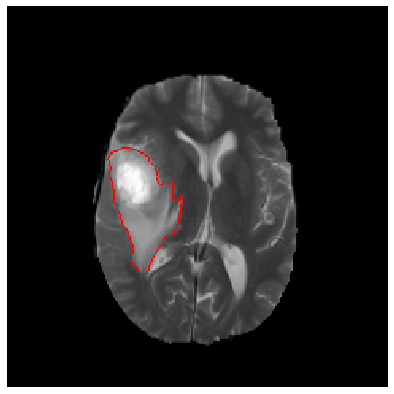

In [4]:
# --- View middle slice
z = int(dat.shape[0] / 2)

# --- Show data
imshow(dat[z], lbl[z])

## Data Client

To efficiently load the data used in this tutorial, a special `Client` class has been prepared that handles many of the low-level tasks that need to be accounted for during algorithm training such as keeping track of training / validation splits and randomization between epochs. Importantly several medical imaging specific functionality has also been accounted for, including stratified sampling by disease entity and statistics for image normalization. For more information about the `Client` class and how to customize, see the following tutorial links (remote/local). 

For this tutorial, we leverage this class by first creating a custom preprocessing method for this experiment:

In [5]:
class MyClient(Client):
    
    def preprocess(self, arrays, meta=None):
        """
        Method to preprocess arrays
        
        :params
        
          (np.ndarray) arrays['dat']: input data
          (np.ndarray) arrays['lbl']: input labels
          (dict) meta : metadata information about current data
        
        """
        # --- Preprocess data
        if meta is not None:
            mu = self.meta['mu'][meta['index']]
            sd = self.meta['sd'][meta['index']]
        else:
            mu = arrays['dat'].mean(axis=(0, 1, 2))
            sd = arrays['dat'].std(axis=(0, 1, 2))
        
        mu = mu.reshape(1, 1, 1, -1)
        sd = sd.reshape(1, 1, 1, -1)
        arrays['dat'] = (arrays['dat'] - mu) / sd
        
        # --- Preprocess labels
        arrays['lbl'] = (arrays['lbl'] >= 1).astype('uint8')
        
        return arrays

Now we will instantiate a new `client` object, set a stratified sampling rate and prepare the first valildation fold. In our experiment, we will choose to stratify our data sampling such that an even 50-50% of loaded examples contain a positive or negative finding.

In [6]:
# --- Instantiate the data client
client = MyClient()

# --- Create cohorts
client.prepare_cohorts(fold=0, cohorts={
    1: lambda x : ~(x[1] | x[2] | x[3] | x[4]),
    2: lambda x : x[1] | x[2] | x[3] | x[4]})

# --- Set 50/50% sampling rate
client.set_sampling_rates({
    1: 0.5,
    2: 0.5})

To use this client to load data, we can either use the `client.get()` method to return a single example via a dictionary of arrays, or instantiate a Python generator that can be used to iterate through an entire batch of data in a memory efficient way.

In [7]:
# --- Define input shape
SHAPE = [1] + list(dat.shape[1:3])

# --- Load a single train/valid using client.get()
arrays = client.get(shape=SHAPE, split='train')
arrays = client.get(shape=SHAPE, split='valid')

# --- Load a single batch via a generator
gen_train = client.generator(shape=SHAPE, split='train', batch_size=16)
gen_valid = client.generator(shape=SHAPE, split='valid', batch_size=16)

batch = next(gen_train)
batch = next(gen_valid)

# Model

In this exercise, we will create a custom variant of the standard contracting-expanding netowrk topology, popularly referred to as a U-Net architecture. We will define the algorithm completely here in the next several code cells using the functional API of Tensorflow/Keras. For a more general overview of basic Tensorflow/Keras usage, see the following tutorial links (remote/local). 

## Creating a Convolutional Block

To help facilitate concise and readable code, we will create template Python lambda functions to succintly define convolutional blocks, defined as the following series of consecutive operations:

* convolution (or convolutional-transpose)
* batch normalization
* activation function (ReLU, leaky ReLU, etc)

In [ ]:
# --- Define convolution parameters
kwargs = {
    'kernel_size': (1, 3, 3),
    'padding': 'same',
    'kernel_initializer': 'he_normal'}

# --- Define block components
conv = lambda x, filters, strides : layers.Conv3D(filters=filters, strides=strides, **kwargs)(x)
tran = lambda x, filters, strides : layers.Conv3DTranspose(filters=filters, strides=strides, **kwargs)(x)
norm = lambda x : layers.BatchNormalization()(x)
relu = lambda x : layers.LeakyReLU()(x)

# --- Define stride-1, stride-2 blocks
conv1 = lambda filters, x : relu(norm(conv(x, filters, 1)))
conv2 = lambda filters, x : relu(norm(conv(x, filters, (1, 2, 2))))
tran2 = lambda filters, x : relu(norm(tran(x, filters, (1, 2, 2)))) 

Now, we are ready to define the full model.

In [ ]:
def create_model(input_shape):
    """
    Method to create simple U-Net architecture

    """
    # --- Define input
    inputs = Input(shape=input_shape)

    # --- Define contracting layers
    l1 = conv1(16, inputs)
    l2 = conv1(32, conv2(32, l1))
    l3 = conv1(48, conv2(48, l2))
    l4 = conv1(64, conv2(64, l3))
    l5 = conv1(80, conv2(80, l4))

    # --- Define expanding layers
    l6 = tran2(64, l5)
    l7 = tran2(48, conv1(64, l6 + l4))
    l8 = tran2(32, conv1(48, l7 + l3))
    l9 = tran2(16, conv1(32, l8 + l2))

    logits = layers.Conv3D(filters=2, **kwargs)(conv1(16, l1 + l9))

    return Model(inputs=inputs, outputs=logits)

In [ ]:
# --- Create model and show summary
model = create_model(arrays['dat'].shape)
model.summary()

## Preparing the Model

Next, we must compile the model with the requisite objects that define traininng dynamics (e.g. how the algorithm with learn). This will include classes that encapsulate the model `optimizer`, `loss` and `metrics` for evaluating algorithm performance. For more information about how these strategies are determined and defined, see the following tutorial links (remote/local).

In [ ]:
# --- Define optimizer
optimizer = optimizers.Adam(learning_rate=2e-4)

# --- Define loss
loss = losses.SparseCategoricalCrossentropy(from_logits=True)

### Custom Metric

In addition the standard evaluation metric of `accuracy` (% of pixels or voxels that are predicted correctly), we will also keep track of a common metric to evaluate spatial overlap of masks: the Dice score. To do so, we need to create a custom metric function. For more information about creating custom metrics (and losses) in Tensorflow/Keras, see the following tutorial links (remote/local).

In [8]:
def metric_dice():

    def dice(y_true, y_pred):

        true = y_true == 1
        pred = y_pred[..., 1] > y_pred[..., 0] 

        A = math.count_nonzero(true & pred) * 2
        B = math.count_nonzero(true) + math.count_nonzero(pred)

        return A / B

    return dice

### Compile

At last we are ready to compile the model. This is done simply with a call using the `model.compile()` method:

In [ ]:
model.compile(
    optimzer=optimizer,
    loss=loss,
    metrics=['accuracy', metric_dice()])

# Training

One of the primary advantages to the Tensorflow/Keras API is that by following the above "recipe" to customize, instantiate and compile a `model` object, several very easy-to-use interfaces are available for algorithm training. In this tutorial, we will use data prepared from generators (`gen_train` and `gen_valid` as above) to train the model using the `model.fit_generator()` method. Usage is shown as follows using a single line of code:

In [ ]:
# --- Train the model
model.fit_generator(
    generator=gen_train,
    steps_per_epoch=500,
    epochs=4,
    validation_data=gen_valid,
    validation_steps=100)

# Prediction

How did we do? The validation performance metrics (accuracy, Dice score) give us a reasonable benchmark, but the most important thing to do at the end of the day is to visually check some examples for yourself. Let us pass some validation data manually into the model using the `model.predict()` method and see some results:

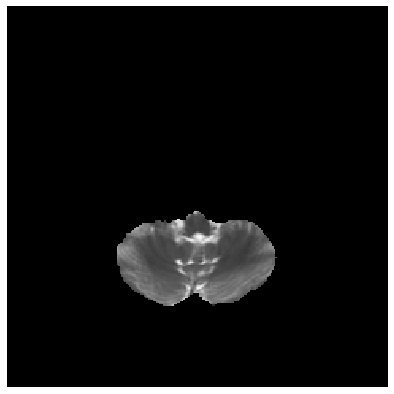

In [13]:
# --- Load data and preproces
arrays = client.get(shape=SHAPE, split='valid')

# --- Run prediction
pred = model.predict(np.expand_dims(arrays['dat'], axis=0))
mask = np.argmax(pred[0], axis=-1)

# --- Show prediction
imshow(arrays['dat'][0, ... ], mask)

## Saving and Loading a Model

After a model has been successfully trained, it can be saved and/or loaded by simply using the `model.save()` and `models.load_model()` methods. Note that any custom losses and/or metrics will need to be provided via a dictionary.

In [ ]:
# --- Serialize a model
os.makedirs('./models', exist_ok=True)
model.save('./models/unet.hdf5')

In [9]:
# --- Load a serialized model
model = models.load_model('./models/unet.hdf5', custom_objects={'dice': metric_dice()})